In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
!pip install keras_tuner
from keras_tuner.tuners import BayesianOptimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.0 MB/s eta 0:00:00


In [3]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download('vencerlanz09/agricultural-pests-image-dataset')

print('Path to dataset files:', dataset_path)

Path to dataset files: /kaggle/input/agricultural-pests-image-dataset


In [4]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30

dataset_contents = os.listdir(dataset_path)
directories = []
for item in dataset_contents:
    if os.path.isdir(os.path.join(dataset_path, item)):
        directories.append(item)

CLASSES = sorted(directories)
NUM_CLASSES = len(CLASSES)
print(CLASSES)

['ants', 'bees', 'beetle', 'catterpillar', 'earthworms', 'earwig', 'grasshopper', 'moth', 'slug', 'snail', 'wasp', 'weevil']


In [5]:
image_paths = []
labels = []

for class_name in CLASSES:
    class_dir = os.path.join(dataset_path, class_name)
    for image_file in os.listdir(class_dir):
        if image_file.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(class_dir, image_file)
            image_paths.append(image_path)
            labels.append(class_name)

df = pd.DataFrame({'image_path': image_paths, 'label': labels})
df

,image_path,label
0,/kaggle/input/agricultural-pests-image-dataset...,ants
1,/kaggle/input/agricultural-pests-image-dataset...,ants
2,/kaggle/input/agricultural-pests-image-dataset...,ants
3,/kaggle/input/agricultural-pests-image-dataset...,ants
4,/kaggle/input/agricultural-pests-image-dataset...,ants
...,...,...
5489,/kaggle/input/agricultural-pests-image-dataset...,weevil
5490,/kaggle/input/agricultural-pests-image-dataset...,weevil
5491,/kaggle/input/agricultural-pests-image-dataset...,weevil
5492,/kaggle/input/agricultural-pests-image-dataset...,weevil


In [6]:
def split_train_testing(df):
    train_val_df, test_df = train_test_split(df, test_size=0.1, random_state=42, shuffle=True)
    train_df, val_df = train_test_split(train_val_df, test_size=2/9, random_state=42, shuffle=True)
    return train_df, val_df, test_df

train_df, val_df, test_df = split_train_testing(df)
print(f'Number of training images: {len(train_df)}')
print(f'Number of validation images: {len(val_df)}')
print(f'Number of testing images: {len(test_df)}')

Number of training images: 3845
Number of validation images: 1099
Number of testing images: 550


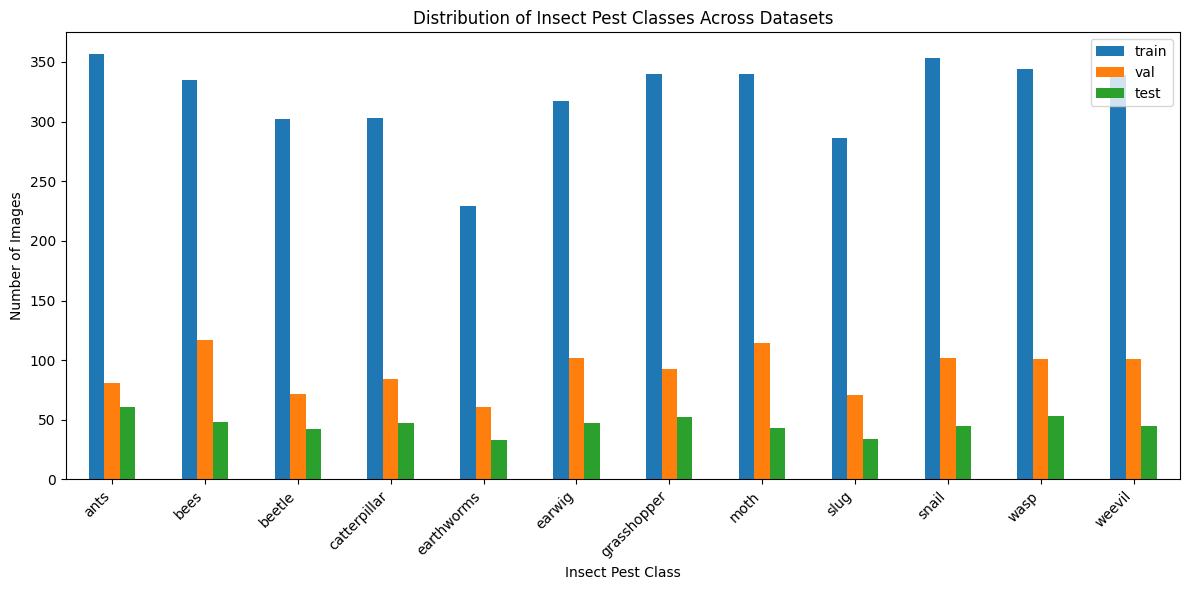

In [7]:
def plot_insect_class_distribution(train_df, val_df, test_df, classes):
    train_counts = train_df['label'].value_counts().sort_index()
    val_counts = val_df['label'].value_counts().sort_index()
    test_counts = test_df['label'].value_counts().sort_index()

    class_distribution_df = pd.DataFrame({
        'train': train_counts,
        'val': val_counts,
        'test': test_counts
    }).fillna(0)

    fig, ax = plt.subplots(figsize=(12, 6))
    class_distribution_df.plot(kind='bar', ax=ax)

    plt.xlabel('Insect Pest Class')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Insect Pest Classes Across Datasets')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_insect_class_distribution(train_df, val_df, test_df, CLASSES)

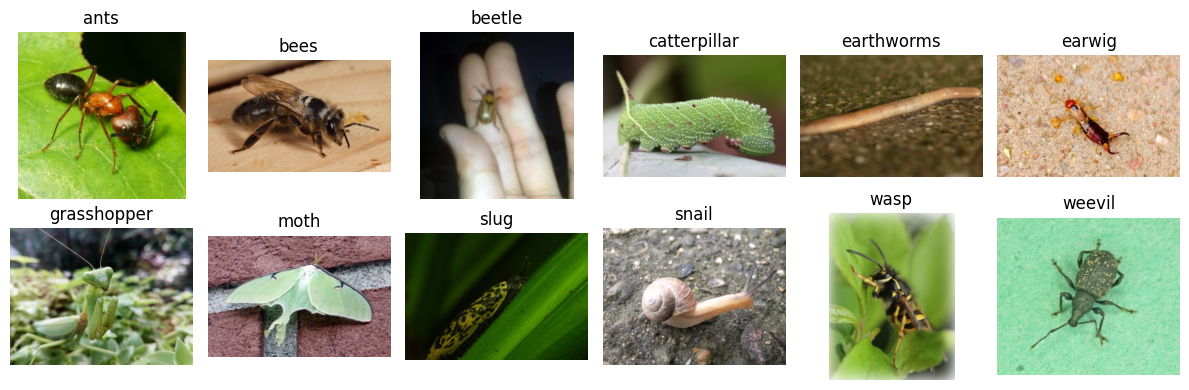

In [8]:
def plot_random_image_per_class(dataset_dir, classes):
    num_classes = len(classes)
    plt.figure(figsize=(12, 4))

    for i, class_name in enumerate(classes):
        class_path = os.path.join(dataset_dir, class_name)
        class_contents = os.listdir(class_path)
        image_files = []
        for item in class_contents:
            if item.endswith(('.jpg', '.jpeg', '.png')):
                image_files.append(item)
        random_image_file = np.random.choice(image_files)
        random_image_path = os.path.join(class_path, random_image_file)
        image = plt.imread(random_image_path)
        plt.subplot(2, num_classes//2, i+1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(class_name)

    plt.tight_layout()
    plt.show()

plot_random_image_per_class(dataset_path, CLASSES)

In [9]:
def build_image_generators(train_df, val_df, test_df, preprocessing_function=None):
  train_generator = ImageDataGenerator(
      preprocessing_function=preprocessing_function,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
  )

  val_generator = ImageDataGenerator(
      preprocessing_function=preprocessing_function
  )

  test_generator = ImageDataGenerator(
      preprocessing_function=preprocessing_function
  )

  train_images = train_generator.flow_from_dataframe(
      dataframe=train_df,
      x_col='image_path',
      y_col='label',
      target_size=IMAGE_SIZE,
      batch_size=BATCH_SIZE,
      color_mode='rgb',
      class_mode='categorical',
      shuffle=True,
      seed=42
  )

  val_images = val_generator.flow_from_dataframe(
      dataframe=val_df,
      x_col='image_path',
      y_col='label',
      target_size=IMAGE_SIZE,
      batch_size=BATCH_SIZE,
      color_mode='rgb',
      class_mode='categorical',
      shuffle=False,
      seed=42
  )

  test_images = test_generator.flow_from_dataframe(
      dataframe=test_df,
      x_col='image_path',
      y_col='label',
      target_size=IMAGE_SIZE,
      batch_size=BATCH_SIZE,
      color_mode='rgb',
      class_mode='categorical',
      shuffle=False,
      seed=42
  )

  return train_images, val_images, test_images

In [10]:
augment = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE[0], IMAGE_SIZE[1]),
    layers.Rescaling(1./255),
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

In [11]:
def build_transfer_learning_model(model_name, num_classes=NUM_CLASSES, trainable=False):
  if model_name == 'EfficientNetV2B0':
    model = applications.EfficientNetV2B0(
        include_top=False,
        weights='imagenet',
        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
    )

  elif model_name == 'ResNet50':
    model = applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
    )

  elif model_name == 'DenseNet121':
    model = applications.DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
    )

  model.trainable = trainable

  inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
  x = augment(inputs)
  x = model(inputs, training=False)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.2)(x)
  outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
  model = Model(inputs, outputs)

  model.compile(
      optimizer=Adam(learning_rate=0.0001),
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )
  model.summary()
  return model

In [12]:
def train_transfer_learning_model(model, train_images, val_images):
  best_weights_path = 'best_weights.weights.h5'

  model_checkpoint = ModelCheckpoint(
      filepath=best_weights_path,
      save_weights_only=True,
      monitor='val_accuracy',
      save_best_only=True,
  )

  early_stop = EarlyStopping(
      monitor='val_loss',
      patience=5,
      restore_best_weights=True
  )

  history = model.fit(
      train_images,
      validation_data=val_images,
      epochs=EPOCHS,
      callbacks=[model_checkpoint, early_stop]
  )

  return history

In [13]:
train_images_efficientnet, val_images_efficientnet, test_images_efficientnet = build_image_generators(train_df, val_df, test_df, preprocessing_function=applications.efficientnet_v2.preprocess_input)
efficientnet_model = build_transfer_learning_model('EfficientNetV2B0')
efficientnet_history = train_transfer_learning_model(efficientnet_model, train_images_efficientnet, val_images_efficientnet)

Found 3845 validated image filenames belonging to 12 classes.
Found 1099 validated image filenames belonging to 12 classes.
Found 550 validated image filenames belonging to 12 classes.
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │        15,372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,934,684 (22.64 MB)

 Trainable params: 15,372 (60.05 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 127s 803ms/step - accuracy: 0.1884 - loss: 2.3432 - val_accuracy: 0.6124 - val_loss: 1.7862
Epoch 2/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 46s 383ms/step - accuracy: 0.5771 - loss: 1.7256 - val_accuracy: 0.7561 - val_loss: 1.3196
Epoch 3/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 46s 384ms/step - accuracy: 0.6954 - loss: 1.3464 - val_accuracy: 0.8053 - val_loss: 1.0309
Epoch 4/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 46s 381ms/step - accuracy: 0.7676 - loss: 1.0938 - val_accuracy: 0.8371 - val_loss: 0.8469
Epoch 5/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 46s 380ms/step - accuracy: 0.7896 - loss: 0.9214 - val_accuracy: 0.8553 - val_loss: 0.7237
Epoch 6/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 46s 380ms/step - accuracy: 0.8239 - loss: 0.7888 - val_accuracy: 0.8726 - val_loss: 0.6331
Epoch 7/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 46s 382ms/step - accuracy: 0.8205 - loss: 0.7423 - val_accuracy: 0.8817 - val_loss: 0.5688
Epoch 8/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 46s 379ms/step - accuracy: 0.8291 - loss: 

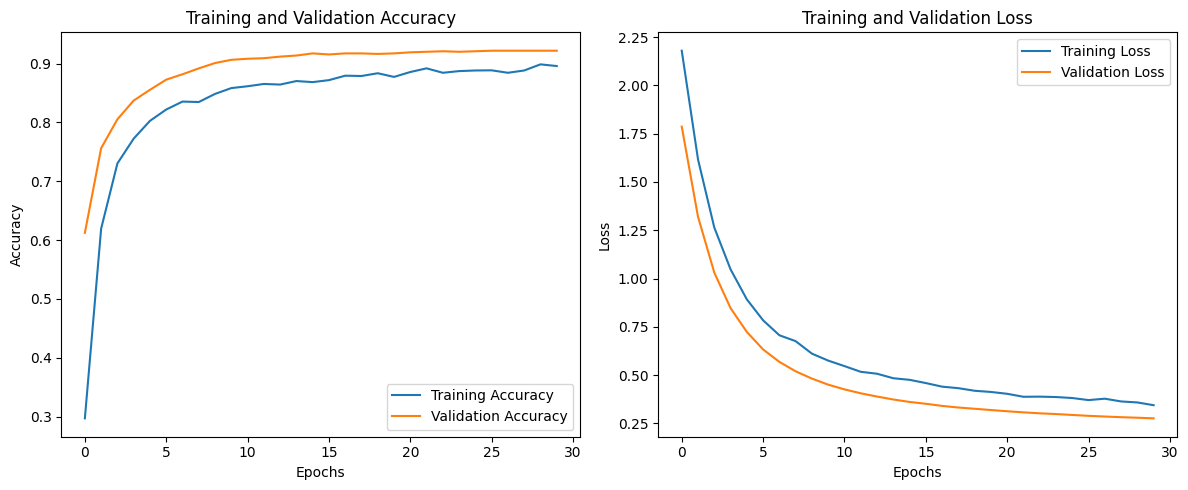

18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 627ms/step - accuracy: 0.9165 - loss: 0.2989
Test Loss (EfficientNetV2B0): 0.2816498577594757
Test Accuracy (EfficientNetV2B0): 0.9200000166893005


In [14]:
def visualize_accuracy_and_loss(history):
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

visualize_accuracy_and_loss(efficientnet_history)
test_loss_efficientnet, test_accuracy_efficientnet = efficientnet_model.evaluate(test_images_efficientnet)
print(f'Test Loss (EfficientNetV2B0): {test_loss_efficientnet}')
print(f'Test Accuracy (EfficientNetV2B0): {test_accuracy_efficientnet}')

18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 409ms/step


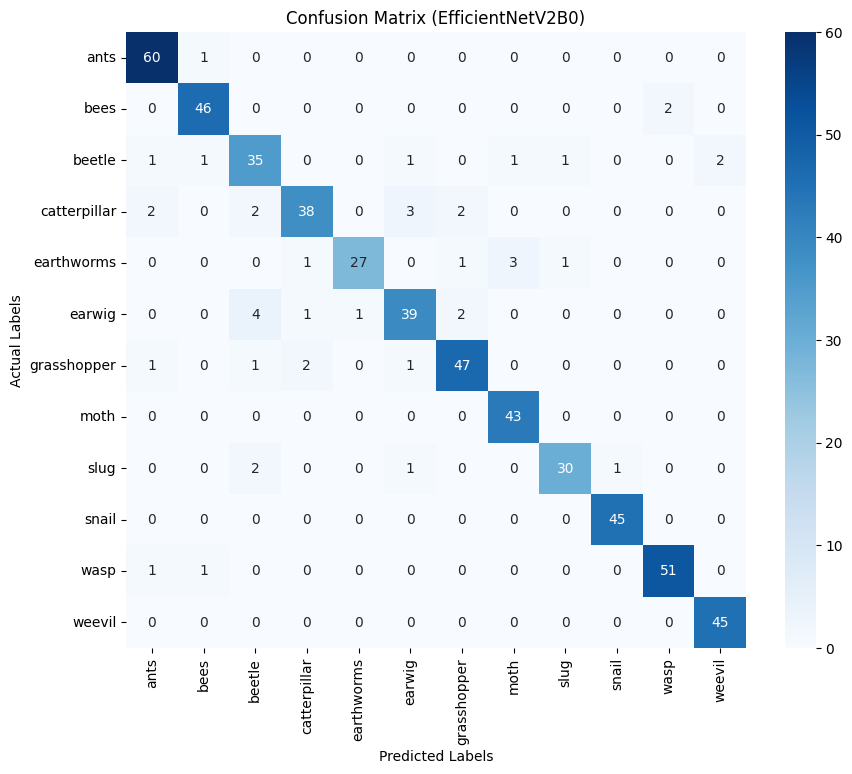

In [15]:
y_pred_efficientnet = efficientnet_model.predict(test_images_efficientnet)
y_pred_classes_efficientnet = np.argmax(y_pred_efficientnet, axis=1)

cm_efficientnet = confusion_matrix(test_images_efficientnet.classes, y_pred_classes_efficientnet)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_efficientnet, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix (EfficientNetV2B0)')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

In [16]:
report_efficientnet = classification_report(test_images_efficientnet.classes, y_pred_classes_efficientnet, output_dict=True)
report_df_efficientnet = pd.DataFrame(report_efficientnet).transpose()
report_df_efficientnet.index = CLASSES + ['accuracy', 'macro avg', 'weighted avg']
report_df_efficientnet[['precision', 'recall', 'f1-score']]

,precision,recall,f1-score
ants,0.923077,0.983607,0.952381
bees,0.938776,0.958333,0.948454
beetle,0.795455,0.833333,0.813953
catterpillar,0.904762,0.808511,0.853933
earthworms,0.964286,0.818182,0.885246
earwig,0.866667,0.829787,0.847826
grasshopper,0.903846,0.903846,0.903846
moth,0.914894,1.000000,0.955556
slug,0.937500,0.882353,0.909091
snail,0.978261,1.000000,0.989011


In [17]:
train_images_resnet, val_images_resnet, test_images_resnet = build_image_generators(train_df, val_df, test_df, preprocessing_function=applications.resnet50.preprocess_input)
resnet_model = build_transfer_learning_model('ResNet50')
resnet_history = train_transfer_learning_model(resnet_model, train_images_resnet, val_images_resnet)

Found 3845 validated image filenames belonging to 12 classes.
Found 1099 validated image filenames belonging to 12 classes.
Found 550 validated image filenames belonging to 12 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │        24,588 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,612,300 (90.07 MB)

 Trainable params: 24,588 (96.05 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 69s 476ms/step - accuracy: 0.1410 - loss: 2.7772 - val_accuracy: 0.5059 - val_loss: 1.6187
Epoch 2/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 47s 390ms/step - accuracy: 0.4698 - loss: 1.6228 - val_accuracy: 0.6888 - val_loss: 1.0742
Epoch 3/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 47s 387ms/step - accuracy: 0.6227 - loss: 1.2097 - val_accuracy: 0.7698 - val_loss: 0.8430
Epoch 4/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 47s 388ms/step - accuracy: 0.6989 - loss: 0.9677 - val_accuracy: 0.8089 - val_loss: 0.7058
Epoch 5/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 47s 387ms/step - accuracy: 0.7516 - loss: 0.8389 - val_accuracy: 0.8380 - val_loss: 0.6139
Epoch 6/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 47s 386ms/step - accuracy: 0.7808 - loss: 0.7176 - val_accuracy: 0.8499 - val_loss: 0.5566
Epoch 7/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 47s 388ms/step - accuracy: 0.7888 - loss: 0.7077 - val_accuracy: 0.8571 - val_loss: 0.5207
Epoch 8/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 47s 386ms/step - accuracy: 0.8029 - loss: 0

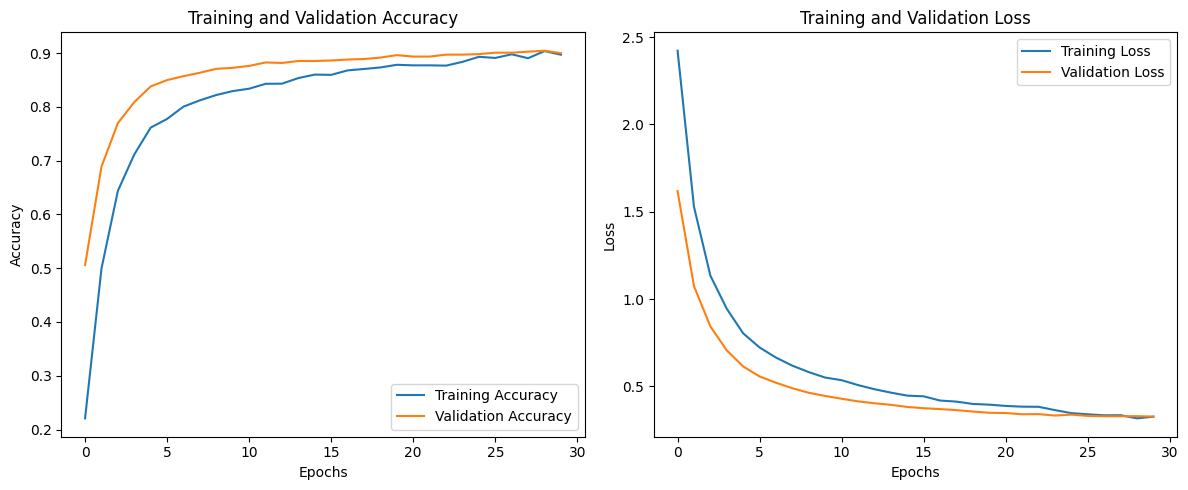

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 245ms/step - accuracy: 0.9094 - loss: 0.3007
Test Loss (ResNet50): 0.31320375204086304
Test Accuracy (ResNet50): 0.8999999761581421


In [18]:
visualize_accuracy_and_loss(resnet_history)
test_loss_resnet, test_accuracy_resnet = resnet_model.evaluate(test_images_resnet)
print(f'Test Loss (ResNet50): {test_loss_resnet}')
print(f'Test Accuracy (ResNet50): {test_accuracy_resnet}')

18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 296ms/step


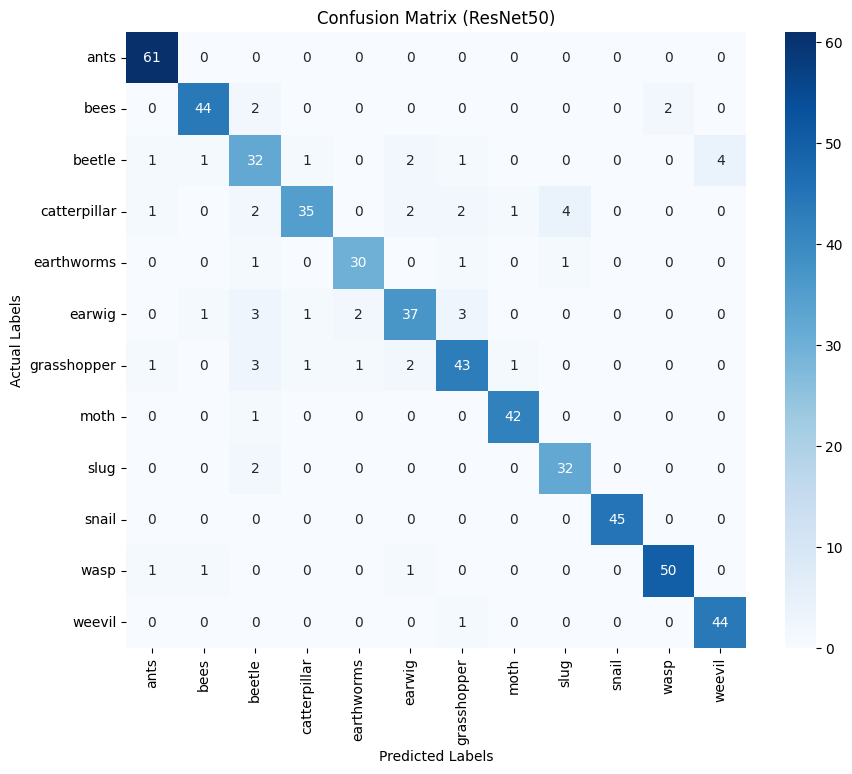

In [19]:
y_pred_resnet = resnet_model.predict(test_images_resnet)
y_pred_classes_resnet = np.argmax(y_pred_resnet, axis=1)

cm_resnet = confusion_matrix(test_images_resnet.classes, y_pred_classes_resnet)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix (ResNet50)')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

In [20]:
report_resnet = classification_report(test_images_resnet.classes, y_pred_classes_resnet, output_dict=True)
report_df_resnet = pd.DataFrame(report_resnet).transpose()
report_df_resnet.index = CLASSES + ['accuracy', 'macro avg', 'weighted avg']
report_df_resnet[['precision', 'recall', 'f1-score']]

,precision,recall,f1-score
ants,0.938462,1.000000,0.968254
bees,0.936170,0.916667,0.926316
beetle,0.695652,0.761905,0.727273
catterpillar,0.921053,0.744681,0.823529
earthworms,0.909091,0.909091,0.909091
earwig,0.840909,0.787234,0.813187
grasshopper,0.843137,0.826923,0.834951
moth,0.954545,0.976744,0.965517
slug,0.864865,0.941176,0.901408
snail,1.000000,1.000000,1.000000


In [21]:
train_images_densenet, val_images_densenet, test_images_densenet = build_image_generators(train_df, val_df, test_df, preprocessing_function=applications.densenet.preprocess_input)
densenet_model = build_transfer_learning_model('DenseNet121')
densenet_history = train_transfer_learning_model(densenet_model, train_images_densenet, val_images_densenet)

Found 3845 validated image filenames belonging to 12 classes.
Found 1099 validated image filenames belonging to 12 classes.
Found 550 validated image filenames belonging to 12 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │        12,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,049,804 (26.89 MB)

 Trainable params: 12,300 (48.05 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 107s 669ms/step - accuracy: 0.1179 - loss: 2.8346 - val_accuracy: 0.2648 - val_loss: 2.1970
Epoch 2/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 48s 392ms/step - accuracy: 0.2627 - loss: 2.2239 - val_accuracy: 0.4577 - val_loss: 1.7561
Epoch 3/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 47s 392ms/step - accuracy: 0.3936 - loss: 1.8700 - val_accuracy: 0.5969 - val_loss: 1.4491
Epoch 4/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 48s 393ms/step - accuracy: 0.5208 - loss: 1.5543 - val_accuracy: 0.6906 - val_loss: 1.2186
Epoch 5/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 48s 396ms/step - accuracy: 0.5948 - loss: 1.3774 - val_accuracy: 0.7389 - val_loss: 1.0599
Epoch 6/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 47s 391ms/step - accuracy: 0.6644 - loss: 1.1954 - val_accuracy: 0.7662 - val_loss: 0.9434
Epoch 7/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 47s 392ms/step - accuracy: 0.6788 - loss: 1.1009 - val_accuracy: 0.7953 - val_loss: 0.8463
Epoch 8/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 48s 393ms/step - accuracy: 0.7219 - loss: 

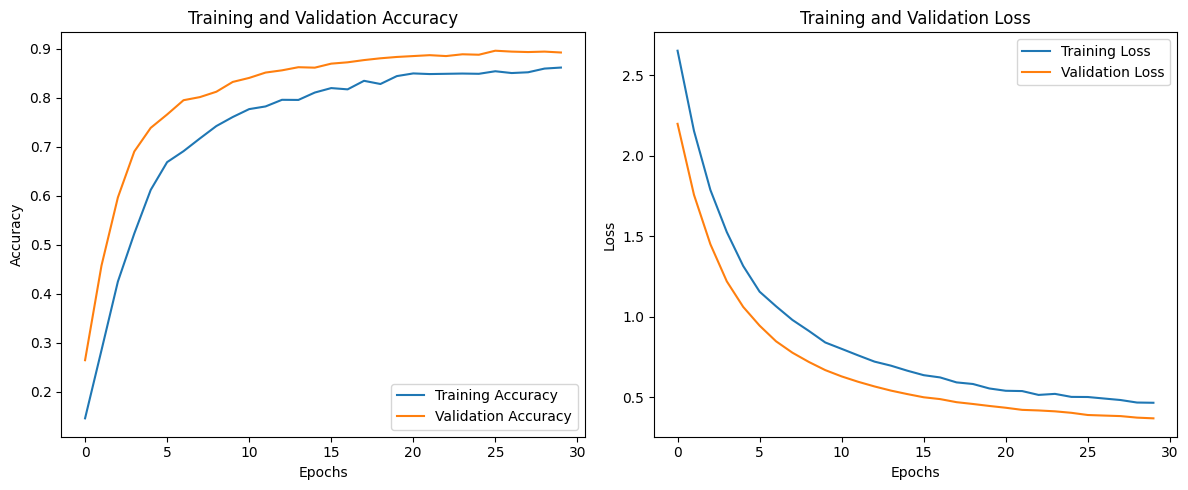

18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 638ms/step - accuracy: 0.9118 - loss: 0.3144
Test Loss (DenseNet121): 0.3364836573600769
Test Accuracy (DenseNet121): 0.8999999761581421


In [22]:
visualize_accuracy_and_loss(densenet_history)
test_loss_densenet, test_accuracy_densenet = densenet_model.evaluate(test_images_densenet)
print(f'Test Loss (DenseNet121): {test_loss_densenet}')
print(f'Test Accuracy (DenseNet121): {test_accuracy_densenet}')

18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 696ms/step


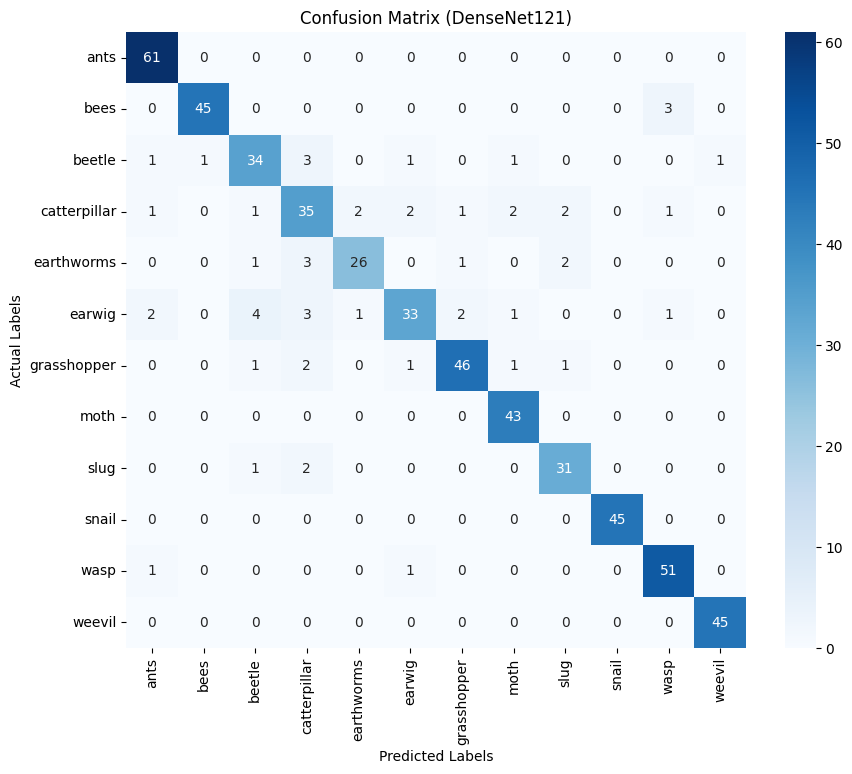

In [23]:
y_pred_densenet = densenet_model.predict(test_images_densenet)
y_pred_classes_densenet = np.argmax(y_pred_densenet, axis=1)

cm_densenet = confusion_matrix(test_images_densenet.classes, y_pred_classes_densenet)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_densenet, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix (DenseNet121)')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

In [30]:
report_densenet = classification_report(test_images_densenet.classes, y_pred_classes_densenet, output_dict=True)
report_df_densenet = pd.DataFrame(report_densenet).transpose()
report_df_densenet.index = CLASSES + ['accuracy', 'macro avg', 'weighted avg']
report_df_densenet[['precision', 'recall', 'f1-score']]

,precision,recall,f1-score
ants,0.924242,1.000000,0.960630
bees,0.978261,0.937500,0.957447
beetle,0.809524,0.809524,0.809524
catterpillar,0.729167,0.744681,0.736842
earthworms,0.896552,0.787879,0.838710
earwig,0.868421,0.702128,0.776471
grasshopper,0.920000,0.884615,0.901961
moth,0.895833,1.000000,0.945055
slug,0.861111,0.911765,0.885714
snail,1.000000,1.000000,1.000000


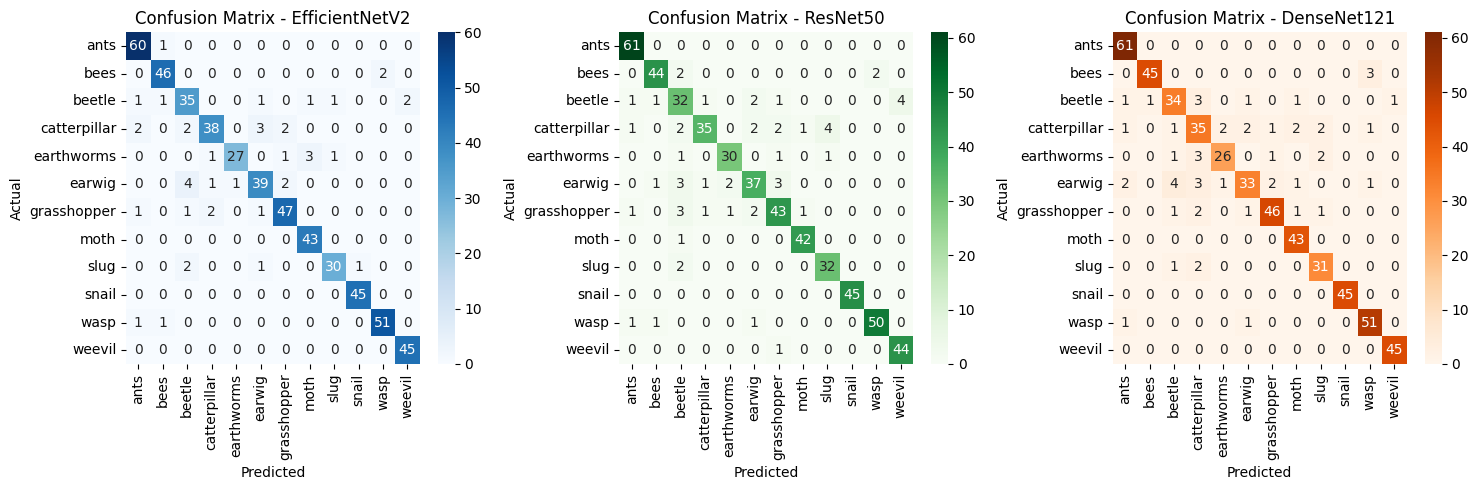

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(cm_efficientnet, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix - EfficientNetV2')

sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Greens',
            xticklabels=CLASSES, yticklabels=CLASSES, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix - ResNet50')

sns.heatmap(cm_densenet, annot=True, fmt='d', cmap='Oranges',
            xticklabels=CLASSES, yticklabels=CLASSES, ax=axes[2])
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_title('Confusion Matrix - DenseNet121')

plt.tight_layout()
plt.show()

In [31]:
def build_custom_model(hp):
    pretrained_model = applications.EfficientNetV2B0(
        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
        include_top=False,
        weights='imagenet'
    )
    pretrained_model.trainable = False

    inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = augment(inputs)
    x = pretrained_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)

    dense_units_1 = hp.Int('dense_units_1', min_value=64, max_value=512, step=64)
    x = Dense(dense_units_1, activation='relu')(x)
    dropout_rate_1 = hp.Float('dropout_rate_1', min_value=0.2, max_value=0.5, step=0.1)
    x = Dropout(dropout_rate_1)(x)

    if hp.Boolean('use_dense_2'):
        dense_units_2 = hp.Int('dense_units_2', min_value=128, max_value=512, step=128)
        x = Dense(dense_units_2, activation='relu')(x)
        dropout_rate_2 = hp.Float('dropout_rate_2', min_value=0.2, max_value=0.5, step=0.1)
        x = Dropout(dropout_rate_2)(x)

    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)

    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [32]:
tuner = BayesianOptimization(
    build_custom_model,
    objective='val_accuracy',
    max_trials=15,
    directory='bayesian_optimization_custom',
    project_name='insect_pest_classification_custom',
    overwrite=True,
    seed=42
)

early_stop_tuning = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(
    train_images_efficientnet,
    epochs=10,
    validation_data=val_images_efficientnet,
    callbacks=[early_stop_tuning]
)

best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print('Best hyperparameters found:', best_hp)

best_custom_model = tuner.get_best_models(num_models=1)[0]
best_custom_model.summary()

Trial 15 Complete [00h 07m 53s]
val_accuracy: 0.9308462142944336

Best val_accuracy So Far: 0.9326660633087158
Total elapsed time: 02h 07m 51s
Best hyperparameters found: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7852e2647090>


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 448)            │       573,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         5,388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,498,588 (24.79 MB)

 Trainable params: 579,276 (2.21 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [33]:
best_custom_model_checkpoint = ModelCheckpoint(
    filepath='best_custom_model_weights.weights.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)

best_custom_model_early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_best_custom_model = best_custom_model.fit(
    train_images_efficientnet,
    validation_data=val_images_efficientnet,
    epochs=EPOCHS,
    callbacks=[best_custom_model_checkpoint, best_custom_model_early_stop]
)

Epoch 1/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 88s 535ms/step - accuracy: 0.9461 - loss: 0.1861 - val_accuracy: 0.9290 - val_loss: 0.2367
Epoch 2/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 46s 377ms/step - accuracy: 0.9543 - loss: 0.1527 - val_accuracy: 0.9227 - val_loss: 0.2400
Epoch 3/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 47s 390ms/step - accuracy: 0.9473 - loss: 0.1494 - val_accuracy: 0.9290 - val_loss: 0.2281
Epoch 4/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 46s 380ms/step - accuracy: 0.9553 - loss: 0.1492 - val_accuracy: 0.9272 - val_loss: 0.2279
Epoch 5/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 46s 377ms/step - accuracy: 0.9569 - loss: 0.1409 - val_accuracy: 0.9281 - val_loss: 0.2346
Epoch 6/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 46s 377ms/step - accuracy: 0.9624 - loss: 0.1204 - val_accuracy: 0.9263 - val_loss: 0.2392
Epoch 7/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 46s 377ms/step - accuracy: 0.9602 - loss: 0.1170 - val_accuracy: 0.9272 - val_loss: 0.2436
Epoch 8/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 45s 374ms/step - accuracy: 0.9640 - loss: 0

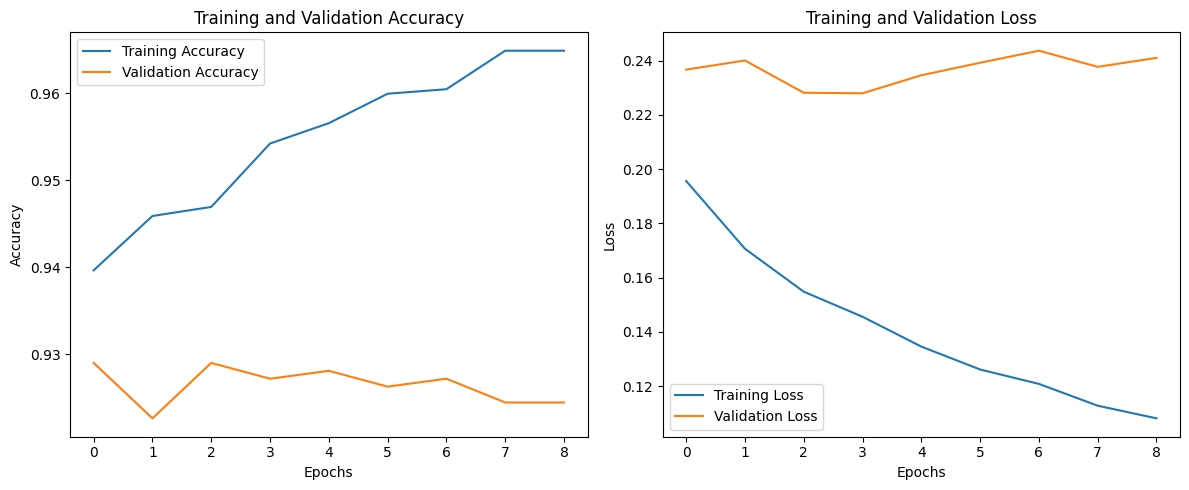

18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 352ms/step - accuracy: 0.9164 - loss: 0.2624
Test Loss (Best Custom Model): 0.23924019932746887
Test Accuracy (Best Custom Model): 0.9272727370262146


In [34]:
visualize_accuracy_and_loss(history_best_custom_model)
test_loss_custom, test_accuracy_custom = best_custom_model.evaluate(test_images_efficientnet)
print(f'Test Loss (Best Custom Model): {test_loss_custom}')
print(f'Test Accuracy (Best Custom Model): {test_accuracy_custom}')

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(y_true, y_pred):
    metrics ={
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred, average='weighted'),
        'f1_score': f1_score(y_true, y_pred, average='weighted')
    }
    return metrics


resnet_metrics = evaluate_model(test_images_resnet.classes, y_pred_classes_resnet)
densenet_metrics = evaluate_model(test_images_densenet.classes, y_pred_classes_densenet)
efficientnet_metrics = evaluate_model(test_images_efficientnet.classes, y_pred_classes_efficientnet)

results = {
    'Model': ['EfficientNetV2B0', 'ResNet50', 'DenseNet121'],
    'Accuracy': [efficientnet_metrics['accuracy'], resnet_metrics['accuracy'], densenet_metrics['accuracy']],
    'Precision': [efficientnet_metrics['precision'], resnet_metrics['precision'], densenet_metrics['precision']],
    'Recall': [efficientnet_metrics['recall'], resnet_metrics['recall'], densenet_metrics['recall']],
    'F1-Score': [efficientnet_metrics['f1_score'], resnet_metrics['f1_score'], densenet_metrics['f1_score']]
}

results_df = pd.DataFrame(results)

print(results_df)

              Model  Accuracy  Precision  Recall  F1-Score
0  EfficientNetV2B0      0.92   0.920325    0.92  0.919142
1          ResNet50      0.90   0.901304    0.90  0.899340
2       DenseNet121      0.90   0.899884    0.90  0.898390


In [37]:
y_pred_custom = best_custom_model.predict(test_images_efficientnet)
y_pred_classes_custom = np.argmax(y_pred_custom, axis=1)

custom_metrics = evaluate_model(test_images_efficientnet.classes, y_pred_classes_custom)

custom_results_df = {
    'Model': ['Best Custom Model'],
    'Accuracy': [custom_metrics['accuracy']],
    'Precision': [custom_metrics['precision']],
    'Recall': [custom_metrics['recall']],
    'F1-Score': [custom_metrics['f1_score']]
}

custom_results_df = pd.DataFrame(custom_results_df)

print(custom_results_df)

18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 430ms/step
               Model  Accuracy  Precision    Recall  F1-Score
0  Best Custom Model  0.927273   0.929977  0.927273  0.927332
